# Read, filter and normalize IAM database.
- Filter annotation errors
- Normalization by line.
- Correct: shear, skew and resize over the baselines


In [1]:
# Path to IAM database
source_path = '../data/IAM/'



import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage

import os
import cv2
import h5py
import sys

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (30, 30)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


/home/jorge/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/jorge/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Read list of words in pandas
array_words=[]
n=0
with open(source_path + 'sources/ascii/words.txt', 'r') as f:
    array_words = []
    for line in f:
        if line[0] !='#':
            lp = line.strip().split(' ')
            n+=1
            array_words.append((lp[0],lp[1],lp[2],lp[3],lp[4],lp[5],lp[6],lp[7],' '.join(lp[8:])))

print(len(array_words))

pd_words = pd.DataFrame(array_words, columns=['id_word','segmentation_result','graylevel_binarize',
                                              'x','y','w','h','grammar_tag','word'])
pd_words['w_char'] = pd_words.apply(lambda row: float(row['w']) / len(row['word']), axis=1)
pd_words['num_chars'] = pd_words.apply(lambda row: len(row['word']), axis=1)
pd_words['line'] = pd_words.apply(lambda row: '-'.join(row['id_word'].split('-')[:-1]), axis=1)
pd_words['page'] = pd_words.apply(lambda row: '-'.join(row['id_word'].split('-')[:-2]), axis=1)


print(pd_words.head)
#115319

115320
<bound method NDFrame.head of                id_word segmentation_result graylevel_binarize     x     y  \
0       a01-000u-00-00                  ok                154   408   768   
1       a01-000u-00-01                  ok                154   507   766   
2       a01-000u-00-02                  ok                154   796   764   
3       a01-000u-00-03                  ok                154   919   757   
4       a01-000u-00-04                  ok                154  1185   754   
5       a01-000u-00-05                  ok                154  1438   746   
6       a01-000u-00-06                  ok                154  1896   757   
7       a01-000u-01-00                  ok                156   395   932   
8       a01-000u-01-01                  ok                156   901   958   
9       a01-000u-01-02                  ok                156  1112   958   
10      a01-000u-01-03                  ok                156  1400   937   
11      a01-000u-01-04                 

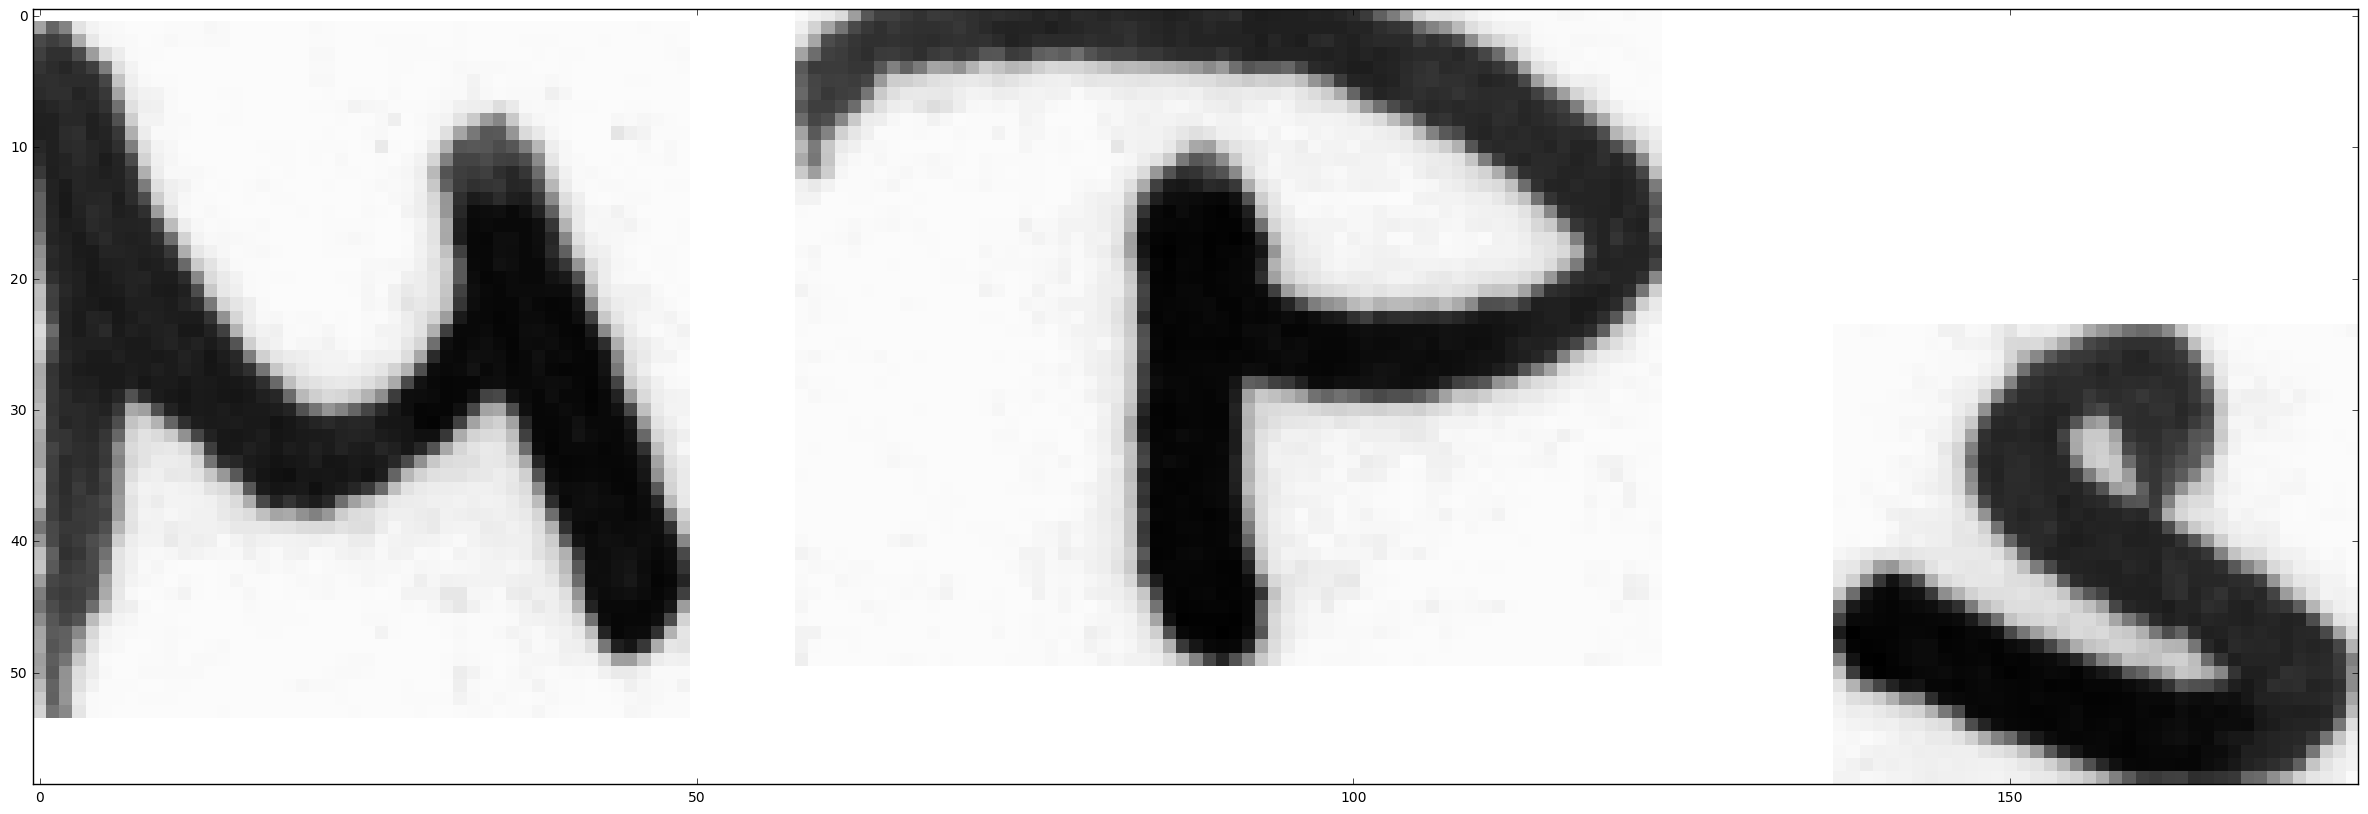

In [20]:
#img = cv2.imread(source_path + '/sources/words/a01/a01-000u/a01-000u-02-08.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread(source_path + '/sources/words/a01/a01-000u/a01-000u-03-00.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

In [3]:
# Clean incorrect words. Select 'segmentation_result == "ok" and word <> "#"'
pd_select_words = pd_words.query('segmentation_result == "ok" and word != "#"')

print(pd_select_words.head)
# 96391

<bound method NDFrame.head of                id_word segmentation_result graylevel_binarize     x     y  \
0       a01-000u-00-00                  ok                154   408   768   
1       a01-000u-00-01                  ok                154   507   766   
2       a01-000u-00-02                  ok                154   796   764   
3       a01-000u-00-03                  ok                154   919   757   
4       a01-000u-00-04                  ok                154  1185   754   
5       a01-000u-00-05                  ok                154  1438   746   
6       a01-000u-00-06                  ok                154  1896   757   
7       a01-000u-01-00                  ok                156   395   932   
8       a01-000u-01-01                  ok                156   901   958   
9       a01-000u-01-02                  ok                156  1112   958   
10      a01-000u-01-03                  ok                156  1400   937   
11      a01-000u-01-04                  ok    

In [4]:
#IAM partition train-valid-test
train_lines = pd.read_csv(source_path + 'split/train.txt', names=['line'])
train_lines['page'] = train_lines.line.apply(lambda x: '-'.join(x.split('-')[:-1]))
train_lines.drop('line', axis=1, inplace=True)
train_lines.drop_duplicates(inplace=True)


valid_lines = pd.read_csv(source_path + 'split/valid.txt', names=['page'])
test_lines = pd.read_csv(source_path + 'split/eval.txt', names=['page'])
train_lines['partition'] = 0
valid_lines['partition'] = 1
test_lines['partition'] = 2

print(train_lines.shape)
print(valid_lines.shape)
print(test_lines.shape)

partition = pd.concat([train_lines, valid_lines, test_lines])

partition

(747, 2)
(116, 2)
(336, 2)


,page,partition
0,a01-000u,0
7,a01-003u,0
18,a01-007u,0
28,a01-011u,0
38,a01-014u,0
46,a01-020u,0
55,a01-026u,0
66,a01-030u,0
77,a01-043u,0
86,a01-049u,0


In [5]:

pd_select_words = pd_select_words.merge(partition, on='page', how='left')
pd_select_words


,id_word,segmentation_result,graylevel_binarize,x,y,w,h,grammar_tag,word,w_char,num_chars,line,page,partition
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,27.000000,1,a01-000u-00,a01-000u,0.0
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,53.250000,4,a01-000u-00,a01-000u,0.0
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,35.000000,2,a01-000u-00,a01-000u,0.0
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,41.500000,4,a01-000u-00,a01-000u,0.0
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,42.000000,3,a01-000u-00,a01-000u,0.0
5,a01-000u-00-05,ok,154,1438,746,382,73,NP,Gaitskell,42.444444,9,a01-000u-00,a01-000u,0.0
6,a01-000u-00-06,ok,154,1896,757,173,72,IN,from,43.250000,4,a01-000u-00,a01-000u,0.0
7,a01-000u-01-00,ok,156,395,932,441,100,VBG,nominating,44.100000,10,a01-000u-01,a01-000u,0.0
8,a01-000u-01-01,ok,156,901,958,147,79,DTI,any,49.000000,3,a01-000u-01,a01-000u,0.0
9,a01-000u-01-02,ok,156,1112,958,208,42,AP,more,52.000000,4,a01-000u-01,a01-000u,0.0


In [6]:
print(pd_select_words.partition.value_counts())


0.0    47952
2.0    20306
1.0     7558
Name: partition, dtype: int64


In [7]:
# Count original words not only the selected over each partition
pd_words_partition = pd_words.merge(partition, on='page', how='left')
print(pd_words_partition.partition.value_counts())
#115320


0.0    55081
2.0    25920
1.0     8895
Name: partition, dtype: int64


# Create normalized words

In [7]:
from sklearn import linear_model
import math
from scipy import ndimage


# Normalization functions
def shear_angle(img, treshold_up = 100, treshold_down = 100):
    '''
    Find shear angle:
    - Check the upper neighboords of pixels with left blank
    '''
    angle = []
    C = 0
    L = 0
    R = 0
    for w in range(1,img.shape[1]-1):
        for h in range(2,img.shape[0]-1):
            if img[h,w] > treshold_up and img[h, w-1] < treshold_down:
                if img[h-1, w-1] > treshold_up:
                    L +=1
                    angle += [-45*1.25]
                elif img[h-1, w] > treshold_up:
                    C += 1
                    angle += [0]
                elif img[h-1, w+1] > treshold_up:
                    R += 1
                    angle += [45*1.25]
    return np.arctan2((R-L),(L+C+R))



def detect_baseline(img, treshold=20):
    '''
    detect baseline
    '''
    low = []
    for w in range(1,img.shape[1]-1):
        if np.max(img[:,w]) > treshold:
            for h in range(img.shape[0]-1, 0, -1):
                if img[h,w] > treshold:
                    low += [[h,w]]
                    break
    points_lower = np.array(low)
    
    #Robust outliers regression
    x = points_lower[:,1].reshape(points_lower.shape[0],1)
    y = points_lower[:,0].reshape(points_lower.shape[0],1)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(x, y)
    y0 = model_ransac.predict(x[0].reshape(1, -1))
    y1 = model_ransac.predict(x[-1].reshape(1, -1))
    y_mean = model_ransac.predict(np.array([img.shape[1]/2]).reshape(1, -1))
    return y0, y1, int(y_mean), np.arctan((y1-y0)/(x[-1]-x[0]))*(180/math.pi)


def detect_upperline(img, treshold=20):
    '''
    detect upperline
    '''
    upp = []
    for w in range(1,img.shape[1]-1):
        if np.max(img[:,w]) > treshold:
            for h in range(img.shape[0]):
                if img[h,w] > treshold:
                    upp += [[h,w]]
                    break
    points_upper = np.array(upp)
    
    #Robust outliers regression
    x = points_upper[:,1].reshape(points_upper.shape[0],1)
    y = points_upper[:,0].reshape(points_upper.shape[0],1)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(x, y)
    y0 = model_ransac.predict(x[0].reshape(1, -1))
    y1 = model_ransac.predict(x[-1].reshape(1, -1))  
    y_mean = model_ransac.predict(np.array([img.shape[1]/2]).reshape(1, -1))
    return y0, y1, int(y_mean)



def proccess_line(img, treshold=128):

    # Correct shear
    angle = shear_angle(img, treshold_up = treshold, treshold_down = treshold)
    M = np.float32([[1, -angle, 0.5*img.shape[0]*angle], [0, 1, 0]])
    img2 = cv2.warpAffine(img,M,(img.shape[1], img.shape[0]),flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)


    #Detect baseline to correct inclination
    y0, y1, y_mean, angle = detect_baseline(img2)
    # Correct inclination with lower angle
    img3 = ndimage.rotate(img2, angle)

    #Detect baseline
    y0, y1, y_mean_base, angle = detect_baseline(img3)

    #Estimate Upper line
    y0, y1, y_mean_upper = detect_upperline(img2, treshold=treshold)

    percent_rescaled = 0.5
    img_sup_rescaled = cv2.resize(img3[:y_mean_upper,:], (img3.shape[1],y_mean_upper//2))

    img_inf_rescaled = cv2.resize(img3[y_mean_base:,:], (img3.shape[1],(img3.shape[0] - y_mean_base)//2))

    img_rescaled = np.concatenate((img_sup_rescaled,img3[y_mean_upper:y_mean_base,:],img_inf_rescaled), axis=0)


    return img_rescaled

In [ ]:
# Test normalization


    
def create_words(line):
    #Read the umbralization treshold
    treshold = 255 - int(pd_select_words[pd_select_words['line']==line]['graylevel_binarize'].max())

    #Read line image and normalize it
    part = line.split('-')
    line_image = path + 'sources/lines/' + part[0] +'/' + part[0] + '-' + part[1] + '/' + line + '.png'
    img = cv2.imread(line_image,cv2.IMREAD_GRAYSCALE)
    img = 255 - img

    try:
        img_rescaled = proccess_line(img, treshold = treshold)
    except:
        img_rescaled = img

    # Save the normalized words
    words_line = pd_select_words[pd_select_words['line']==line]
    fig = plt.figure()
    words_list = []
    words_names = []
    for i, word in enumerate(words_line[:].iterrows()):
        words_names += [word[1].id_word]
        if i==0:
            base_position = int(word[1].x)
        x_ini = int(word[1].x)
        w     = int(word[1].w)
        if w > 10:
            words_list +=[img_rescaled[:, x_ini - base_position : x_ini - base_position + w + 1]]
        else:
            words_list +=[img_rescaled[:, x_ini - base_position - (10-w) : x_ini - base_position + w + (10-w)]]
    return img, img_rescaled, words_list, words_names


def save_word(path_normalized, word, img):
    sw = word.split('-')
    if not os.path.exists(path_normalized + sw[0]):
        os.makedirs(path_normalized + sw[0])
    if not os.path.exists(path_normalized + sw[0] +'/' + sw[0] + '-' + sw[1]):
        os.makedirs(path_normalized + sw[0] +'/' + sw[0] + '-' + sw[1])
    f = path_normalized + sw[0] +'/' + sw[0] + '-' + sw[1] + '/' + word + '.png'
    cv2.imwrite(f,255-img)
    #plt.imshow(img)


In [ ]:
img, img_rescaled, word_list, words_names = create_words('r06-143-04')
print(words_names)
fig = plt.figure()
for i, word in enumerate(word_list):
    a=fig.add_subplot(len(word_list), 1, i+1)
    plt.imshow(word)


In [ ]:
plt.imshow(img) 

In [ ]:
plt.imshow(img_rescaled) 

In [ ]:
# more that 20 hours

trn_lines = pd_select_words.loc[pd_select_words['partition'] == 0].line

for line in trn_lines:
    # Normalize line
    img_line, img_line_normalized, word_list, word_names = create_words(line)
    plt.close('all')
    #Save normalized lines
    cv2.imwrite(source_path + 'lines_normalized/trn/' + line + '.png', 255-img_line_normalized)
    # Save the normalized words
    for i, word in enumerate(word_names):
        save_word(source_path + 'words_normalized/trn/', word, word_list[i])

print( 'Done!')


Done!


In [ ]:
# more that 20 hours

val_lines = pd_select_words.loc[pd_select_words['partition'] == 1].line

for line in val_lines:
    # Normalize line
    img_line, img_line_normalized, word_list, word_names = create_words(line)
    plt.close('all')
    #Save normalized lines
    cv2.imwrite(source_path + 'lines_normalized/val/' + line + '.png', 255-img_line_normalized)
    # Save the normalized words
    for i, word in enumerate(word_names):
        save_word(source_path + 'words_normalized/val/', word, word_list[i])

print( 'Done!')


Done!


In [ ]:
# more that 20 hours

tst_lines = pd_select_words.loc[pd_select_words['partition'] == 2].line

for line in tst_lines:
    # Normalize line
    img_line, img_line_normalized, word_list, word_names = create_words(line)
    plt.close('all')
    #Save normalized lines
    cv2.imwrite(source_path + 'lines_normalized/tst/' + line + '.png', 255-img_line_normalized)
    # Save the normalized words
    for i, word in enumerate(word_names):
        save_word(source_path + 'words_normalized/tst/', word, word_list[i])

print( 'Done!')


Done!


# Step 2: create hdf5 file with fixed size images and targets

- Readed and filtered words list: pd_select_words
- For each, if normalized image exist: load and resize and cummulate in X, X_len, y and y_len.
- Create and save encoder-decoder dictionariy characters.


In [26]:
# Create character dictionary encoder and decoder
labels_trn = pd_select_words.loc[pd_select_words['partition'] == 0].word
labels_val = pd_select_words.loc[pd_select_words['partition'] == 1].word
labels_tst = pd_select_words.loc[pd_select_words['partition'] == 2].word


def char_set(df):
    c_list = []
    for w in df:
        c_list += w
    return set(c_list)

s_trn = char_set(labels_trn)
s_val = char_set(labels_val)
s_tst = char_set(labels_tst)

print('trn - tst: ', s_trn - s_tst)
print('tst - trn: ', s_tst - s_trn)
print('trn - val: ', s_trn - s_val)
print('val - trn: ', s_val - s_trn)

char_set = s_trn

# Dictionary used in seq2seq paper
decoder_dict = {0: '0', 1: '!', 2: 'L', 3: 'z', 4: 'G', 5: 'm', 6: '6', 7: '/', 8: 'j', 9: 's', 10: 'S', 11: '5',
                12: 'R', 13: ')', 14: 'u', 15: 'y', 16: '9', 17: 'g', 18: '3', 19: '1', 20: 'e', 21: "'", 22: ':',
                23: 'Q', 24: '2', 25: 'a', 26: 't', 27: 'A', 28: '7', 29: ';', 30: 'i', 31: 'H', 32: 'W', 33: ',',
                34: '(', 35: 'O', 36: 'U', 37: 'K', 38: 'd', 39: '*', 40: '.', 41: '?', 42: 'q', 43: '-', 44: 'r',
                45: 'n', 46: '&', 47: 'C', 48: '"', 49: 'h', 50: 'v', 51: 'f', 52: 'E', 53: 'p', 54: 'x', 55: '+',
                56: 'w', 57: 'b', 58: 'o', 59: ' ', 60: 'B', 61: 'P', 62: 'D', 63: 'I', 64: 'J', 65: 'V', 66: 'N',
                67: 'M', 68: '8', 69: 'k', 70: 'c', 71: '4', 72: 'T', 73: 'X', 74: 'l', 75: 'Z', 76: 'F', 77: 'Y'}


encoder_dict = {v: k for k, v in decoder_dict.items()}

list_chars = []
list_codes = []
for c in decoder_dict:
    list_chars += [decoder_dict[c].encode('utf8')]
    list_codes += [c]
    
print(encoder_dict)
print(decoder_dict)
print('-------------')
print(list_chars)
print(list_chars[0].decode('utf8'))

trn - tst:  {'/', 'X', '+', '*', 'Z'}
tst - trn:  set()
trn - val:  {'X', '+', '&', '/'}
val - trn:  set()
{"'": 21, '9': 16, '7': 28, '4': 71, 'w': 56, 'X': 73, '2': 24, 'x': 54, ' ': 59, 'Q': 23, '"': 48, '!': 1, 'P': 61, ':': 22, 'S': 10, 'b': 57, 'e': 20, 'N': 66, '8': 68, 'E': 52, '*': 39, 'L': 2, ',': 33, 'M': 67, 'g': 17, 'o': 58, '/': 7, 'Z': 75, 'A': 27, 'q': 42, 'W': 32, 'n': 45, 'l': 74, 'H': 31, 'U': 36, 'u': 14, '(': 34, 'z': 3, 't': 26, 'C': 47, '6': 6, '-': 43, '+': 55, 'G': 4, '5': 11, 's': 9, '1': 19, 'h': 49, 'a': 25, 'B': 60, 'm': 5, 'k': 69, '?': 41, 'd': 38, 'i': 30, 'K': 37, 'J': 64, 'V': 65, '.': 40, 'j': 8, 'I': 63, ')': 13, 'f': 51, 'v': 50, 'p': 53, 'r': 44, 'T': 72, 'y': 15, 'Y': 77, 'O': 35, '&': 46, '0': 0, '3': 18, 'c': 70, 'R': 12, 'D': 62, 'F': 76, ';': 29}
{0: '0', 1: '!', 2: 'L', 3: 'z', 4: 'G', 5: 'm', 6: '6', 7: '/', 8: 'j', 9: 's', 10: 'S', 11: '5', 12: 'R', 13: ')', 14: 'u', 15: 'y', 16: '9', 17: 'g', 18: '3', 19: '1', 20: 'e', 21: "'", 22: ':', 23

In [27]:
# Check target length
print(np.max([len(t) for t in pd_select_words.loc[pd_select_words['partition'] == 0].word]))
print(np.max([len(t) for t in pd_select_words.loc[pd_select_words['partition'] == 1].word]))
print(np.max([len(t) for t in pd_select_words.loc[pd_select_words['partition'] == 2].word]))


19
16
21


(60, 232)
[255  70  94 158 206 221 224 225 207 145  76  91 127 182 159 113  88  80
  90 113 161 253 255 244 186 105  70  84 110 118 124 132 143 130  90  69
  77 126 216 255 255 228 125 133 174 214 215 194 165 115  75  61  65 115
 198 232 254 255 255 255 255 221  92  68  73 114 202 222 207 152  71  54
  63  69  73  74  72  87 163 253 255 255 255 255 248 203 121  66  71 111
 191 232 239 241 243 242 241 243 255 255 248 215 162  87  71  71  73 100
 139 169 181 192 201 186 159 129 120 100 100 129 210 254 255 255 255 249
 220 174 111  70  60  64  71  77  73  67  76  91 141 194 222 231 228 232
 255 228 124  83  66  72 119 205 232 235 236 232 207 131  63  67  90 170
 253 255 255 249 222 183 108  76  79 118 186 229 239 241 242 237 237 237
 225 197 153 121 105 118 122 155 217 254 255 255 255 233 155 143 135 127
 121 102  80  73  68  69  71  73  78  83 112 159 218 243 255 255 255 255
 255 245 193 116  87  90  77  75  78  92 135 196 232 245 251 255]


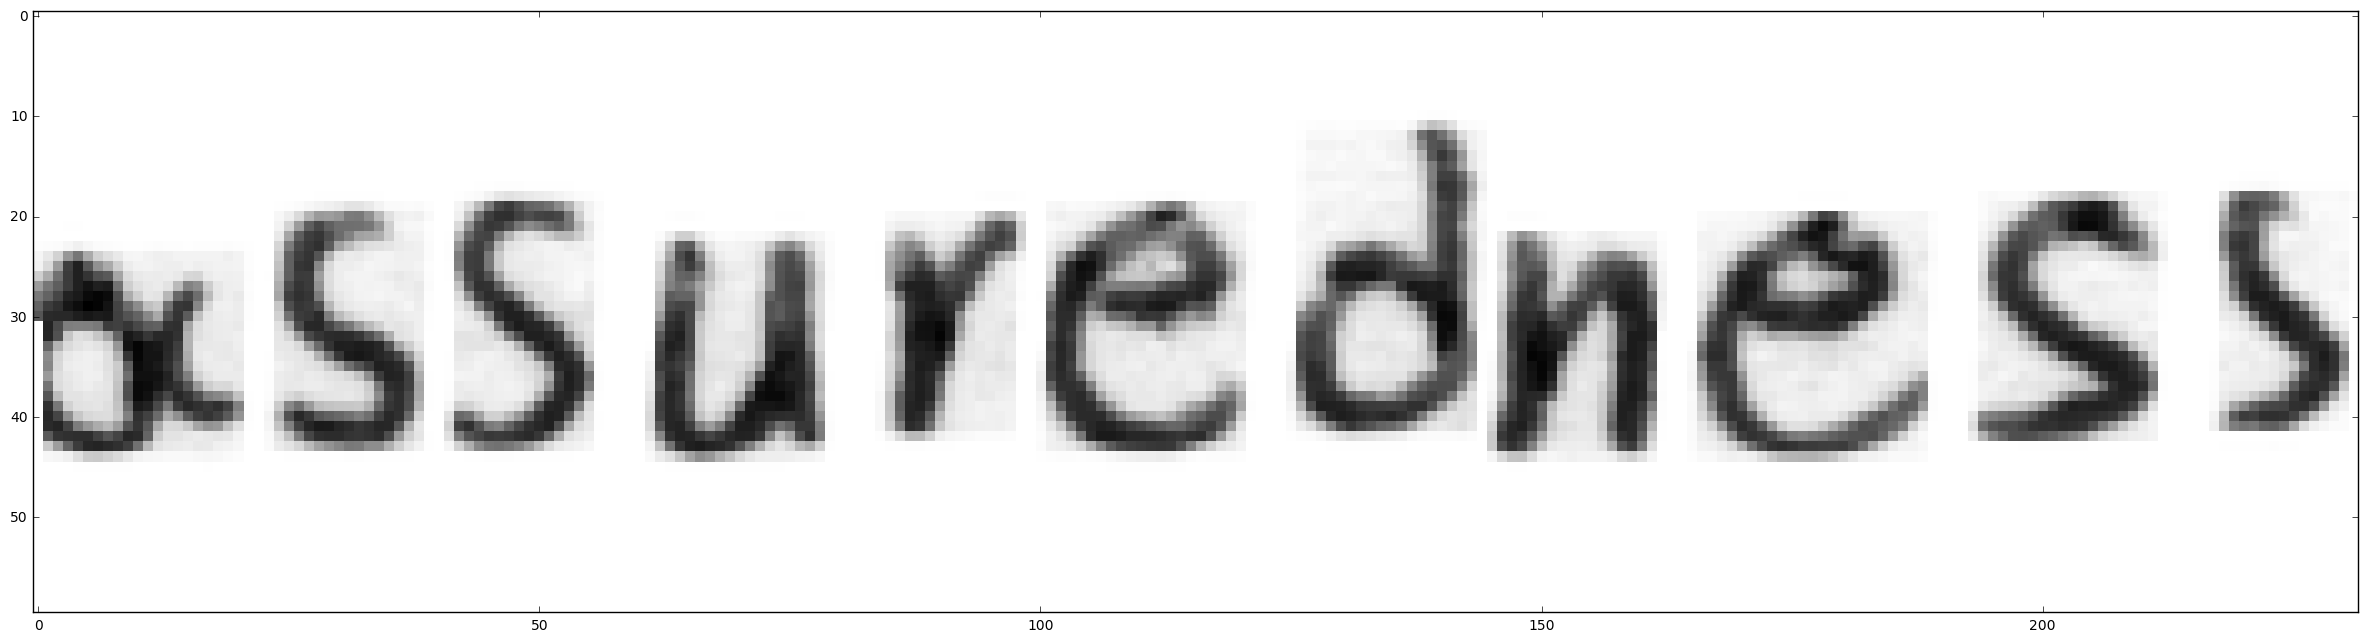

In [28]:
# Sample image
img = cv2.imread(source_path + '/words_normalized/tst/c04/c04-110/c04-110-01-00.png', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(source_path + '/words_normalized/trn/a06/a06-075/a06-075-00-00.png', cv2.IMREAD_GRAYSCALE)
print(img.shape)
print(img[40])
plt.imshow(img)

187


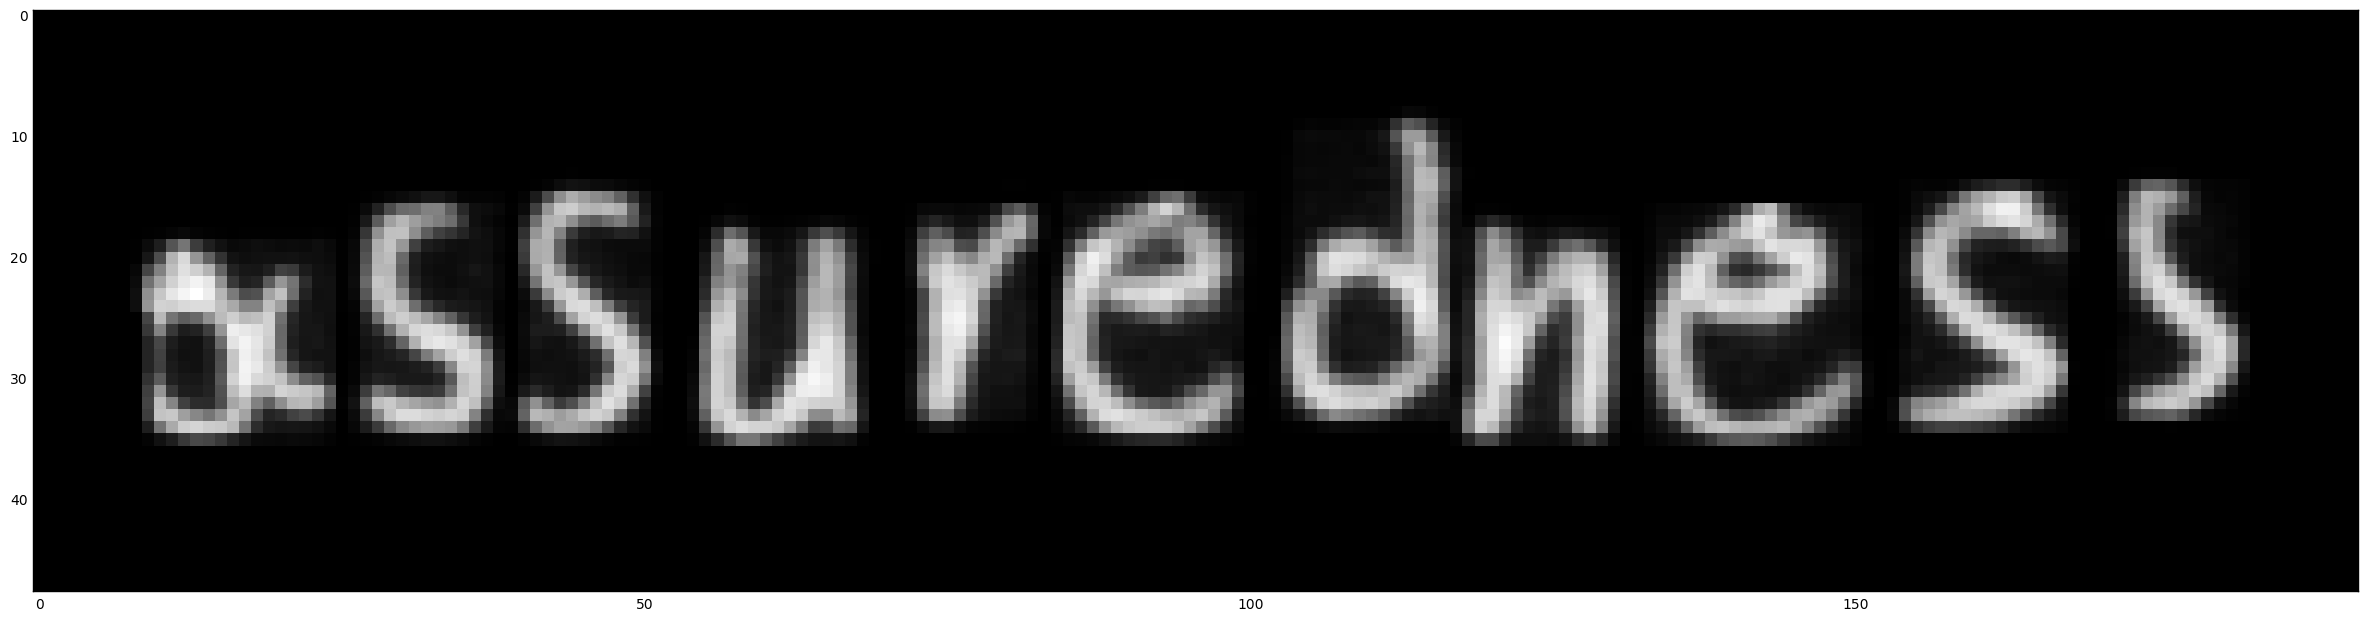

In [29]:
# The final shape must be 48 x 192
# if w > h*4 --> resize to (h, h*4)
# else complete at the left with 0
# Next resize to 48x192

def transform_image(img, x_size=192, y_size=48):

    # add treshold
    gray_level = np.vectorize(lambda x: 0 if x > 253 else 255-x)
    img2 = gray_level(img)

    # Add borders
    h, w = img2.shape
    dh = int(h*0)
    dw = int(w*0.05)+1
    img3 = np.zeros([h+2*dh, w+2*dw], dtype=np.uint8)
    img3[:, dw:-dw] = img2

    # Resize
    h, w = img3.shape
    if w >= h*4:
        img4 = cv2.resize(img3, (h*4, h)) #shape in cv2 is [w,h]
    else:
        img4 = np.zeros([h, h*4], dtype=np.uint8)
        img4[:, 0:w] = img3
    img5 = cv2.resize(img4, (x_size, y_size)) 
    
    # Calculate length of the image: The last non-zero column + 5 
    col_sum = np.sum(i for i in img5)
    last_place = 0
    for i, s in enumerate(col_sum):
        if s > 1:
            last_place = i
    img_len = min(x_size, 5+last_place)
    return img5, img_len

img_t, img_len = transform_image(img)
plt.imshow(img_t)
print(img_len)

In [30]:

def transform_and_save(ds_type='trn', ds_id = 0, filename="IAM_words_48_192.hdf5", x_size=192, y_size=48):
    X = []
    image_length = []
    target = []
    target_length = []
    names_of_files = []
    max_target_len = 19

    for i, row in pd_select_words.loc[pd_select_words['partition'] == ds_id].iloc[:].iterrows():
        if i%1000==0:
            print(i)
        file_name = source_path + 'words_normalized/' + ds_type + '/' + row.page.split('-')[0] + '/' + row.page + '/' + row.id_word + '.png'
        if os.path.isfile(file_name) and len(row.word) <= max_target_len: 
            correct = True
            try:
                #Read image
                img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
                img_t, img_len = transform_image(img, x_size=x_size, y_size=y_size)        
                t = np.ones([max_target_len])*100
                for j, c in enumerate(row.word):
                    t[j] = encoder_dict[c]
            except:
                correct = False
                print( 'Error in image ',i, file_name)
                print( 'Error: ', sys.exc_info()[0])
            if correct:
                X += [img_t]
                image_length += [img_len]
                target += [t]
                target_length += [len(row.word)]
                names_of_files += [row.id_word]
                


    # Save in HDF5
    with h5py.File(source_path + filename) as hdf5_f:
        if "X_" + ds_type in hdf5_f:
            del hdf5_f["X_" + ds_type]
        hdf5_f.create_dataset("X_" + ds_type, data = X) 

        if "image_length_" + ds_type in hdf5_f:
            del hdf5_f["image_length_" + ds_type]
        hdf5_f.create_dataset("image_length_" + ds_type, data = image_length) 

        if "target_"+ds_type in hdf5_f:
            del hdf5_f["target_" + ds_type]
        hdf5_f.create_dataset("target_" + ds_type, data = target) 

        if "target_length_" + ds_type in hdf5_f:
            del hdf5_f["target_length_" + ds_type]
        hdf5_f.create_dataset("target_length_" + ds_type, data = target_length)  
        
        if "filename_" + ds_type in hdf5_f:
            del hdf5_f["filename_" + ds_type]
        names_of_files = [n.encode("ascii", "ignore") for n in names_of_files]
        hdf5_f.create_dataset("filename_" + ds_type, (len(names_of_files),1), 'S20', data = names_of_files)  
    print('Done!')

# Create file for 48x192 shape

In [31]:
with h5py.File(source_path + "IAM_words_48_192.hdf5") as hdf5_f:
    if "target_dict_keys" in hdf5_f:
        del hdf5_f["target_dict_keys"]
    hdf5_f.create_dataset("target_dict_keys", data = list_codes) 

    if "target_dict_values" in hdf5_f:
        del hdf5_f["target_dict_values"]
    hdf5_f.create_dataset("target_dict_values", data = list_chars) 


In [32]:
transform_and_save(ds_type='trn', ds_id = 0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Error in image  11802 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/a06/a06-075/a06-075-00-00.png
Error:  <class 'TypeError'>
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
28000
35000
36000
Error in image  36077 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/e04/e04-058/e04-058-05-00.png
Error:  <class 'TypeError'>
38000
39000
40000
41000
49000
Error in image  49129 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-011c/g06-011c-03-00.png
Error:  <class 'TypeError'>
Error in image  49997 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-011m/g06-011m-03-00.png
Error:  <class 'TypeError'>
50000
51000
Error in image  51030 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-018h/g06-018h-07-03.png
Error:  <class 'TypeError'>
52000
Error in image  52767 /home/j

In [33]:
transform_and_save(ds_type='val', ds_id = 1)

30000
37000
48000
79000
80000
82000
84000
89000
Done!


In [34]:
transform_and_save(ds_type='tst', ds_id = 2)

27000
29000
Error in image  30767 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/d05/d05-013/d05-013-03-00.png
Error:  <class 'TypeError'>
31000
32000
33000
Error in image  33335 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/d07/d07-102/d07-102-02-00.png
Error:  <class 'TypeError'>
34000
42000
43000
44000
45000
46000
Error in image  46485 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/g02/g02-073/g02-073-00-00.png
Error:  <class 'TypeError'>
47000
78000
81000
Error in image  82807 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-031/m06-031-01-00.png
Error:  <class 'TypeError'>
Error in image  82959 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-056/m06-056-01-00.png
Error:  <class 'TypeError'>
83000
Error in image  83019 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-067/m06-067-00-00.png
Error:  <class 'TypeError'>
Error in i

In [35]:
with h5py.File(source_path + "IAM_words_48_192.hdf5", mode='r') as hdf5_f:

    for d in hdf5_f.keys():
        print(hdf5_f[d].name, ' - ', len(hdf5_f[d]))

/X_trn  -  47926
/X_tst  -  20292
/X_val  -  7558
/filename_trn  -  47926
/filename_tst  -  20292
/filename_val  -  7558
/image_length_trn  -  47926
/image_length_tst  -  20292
/image_length_val  -  7558
/target_dict_keys  -  78
/target_dict_values  -  78
/target_length_trn  -  47926
/target_length_tst  -  20292
/target_length_val  -  7558
/target_trn  -  47926
/target_tst  -  20292
/target_val  -  7558


100 [  25.   56.   25.   15.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.] 4 [b'f04-074-01-04']


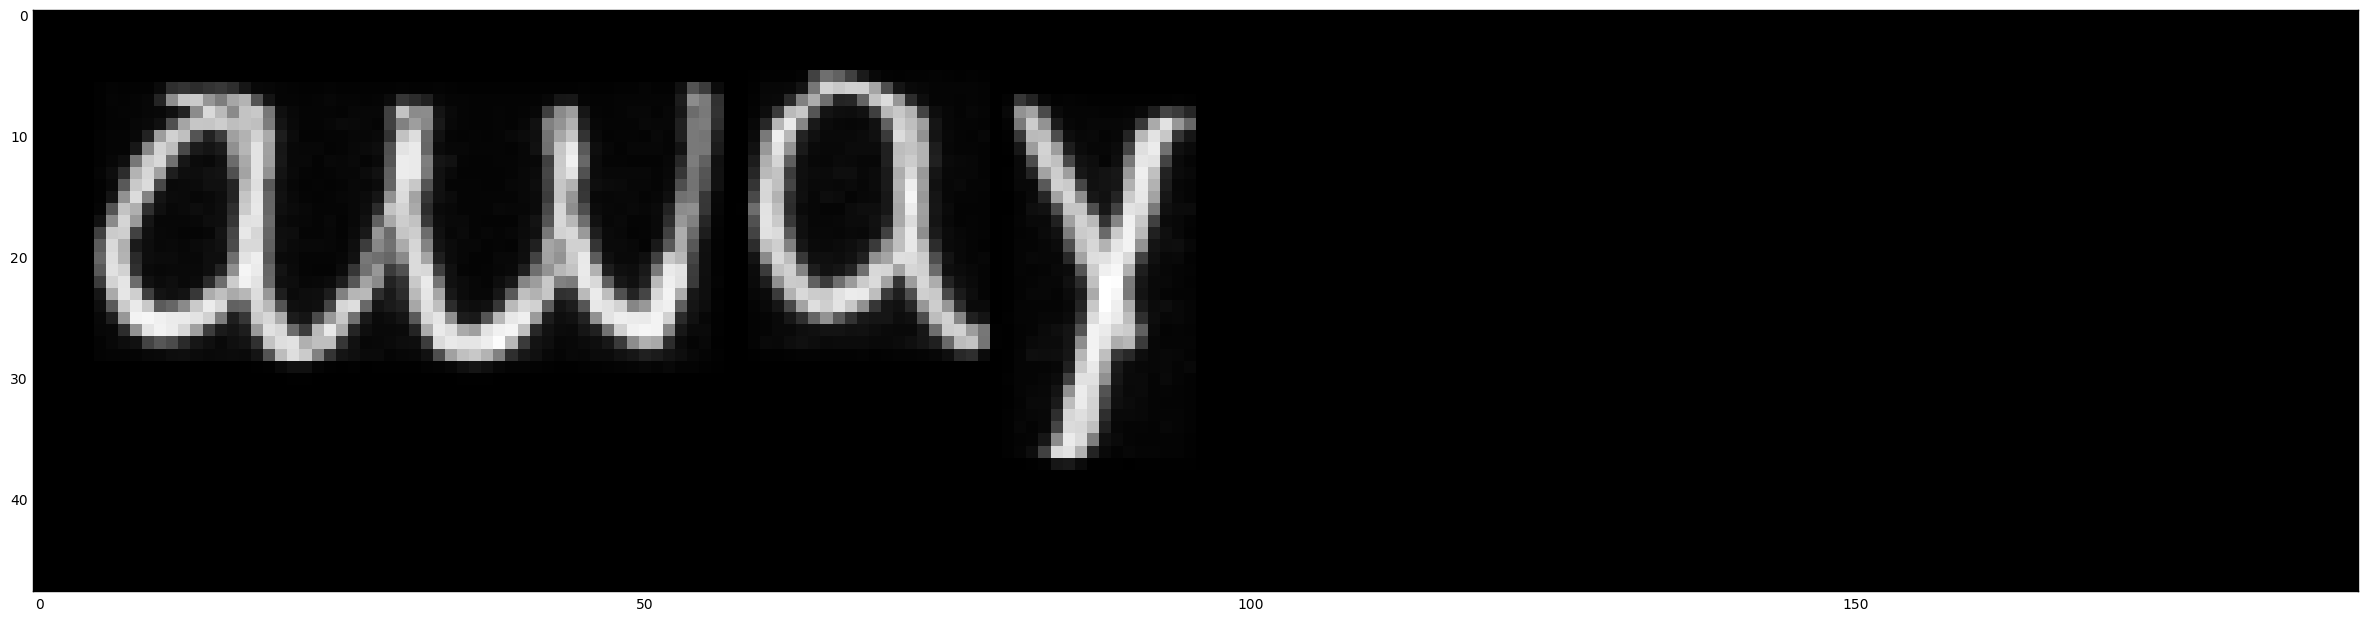

In [36]:
#Check data
i=5900
with h5py.File(source_path + "IAM_words_48_192.hdf5", mode='r') as hdf5_f:
    plt.imshow(hdf5_f.get('X_tst')[i])
    print(hdf5_f.get('image_length_tst')[i], hdf5_f.get('target_tst')[i],
          hdf5_f.get('target_length_tst')[i], hdf5_f.get('filename_tst')[i])

# Generate images of  x_size=256 and y_size=64

In [12]:
file_name = "IAM_words_64_256.hdf5"

with h5py.File(source_path + file_name) as hdf5_f:
    if "target_dict_keys" in hdf5_f:
        del hdf5_f["target_dict_keys"]
    hdf5_f.create_dataset("target_dict_keys", data = list_codes) 

    if "target_dict_values" in hdf5_f:
        del hdf5_f["target_dict_values"]
    hdf5_f.create_dataset("target_dict_values", data = list_chars) 


In [13]:
transform_and_save(ds_type='trn', ds_id = 0, filename=file_name, x_size=256, y_size=64)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Error in image  11802 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/a06/a06-075/a06-075-00-00.png
Error:  <class 'TypeError'>
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
28000
35000
36000
Error in image  36077 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/e04/e04-058/e04-058-05-00.png
Error:  <class 'TypeError'>
38000
39000
40000
41000
49000
Error in image  49129 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-011c/g06-011c-03-00.png
Error:  <class 'TypeError'>
Error in image  49997 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-011m/g06-011m-03-00.png
Error:  <class 'TypeError'>
50000
51000
Error in image  51030 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/trn/g06/g06-018h/g06-018h-07-03.png
Error:  <class 'TypeError'>
52000
Error in image  52767 /home/j

In [14]:
transform_and_save(ds_type='val', ds_id = 1, filename=file_name, x_size=256, y_size=64)

30000
37000
48000
79000
80000
82000
84000
89000
Done!


In [15]:
transform_and_save(ds_type='tst', ds_id = 2, filename=file_name, x_size=256, y_size=64)

27000
29000
Error in image  30767 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/d05/d05-013/d05-013-03-00.png
Error:  <class 'TypeError'>
31000
32000
33000
Error in image  33335 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/d07/d07-102/d07-102-02-00.png
Error:  <class 'TypeError'>
34000
42000
43000
44000
45000
46000
Error in image  46485 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/g02/g02-073/g02-073-00-00.png
Error:  <class 'TypeError'>
47000
78000
81000
Error in image  82807 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-031/m06-031-01-00.png
Error:  <class 'TypeError'>
Error in image  82959 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-056/m06-056-01-00.png
Error:  <class 'TypeError'>
83000
Error in image  83019 /home/jorge/data/tesis/handwriting/databases/IAM/words_normalized/tst/m06/m06-067/m06-067-00-00.png
Error:  <class 'TypeError'>
Error in i

In [16]:
with h5py.File(data_path + file_name, mode='r') as hdf5_f:

    for d in hdf5_f.keys():
        print(hdf5_f[d].name, ' - ', len(hdf5_f[d]))

/X_trn  -  47926
/X_tst  -  20292
/X_val  -  7558
/image_length_trn  -  47926
/image_length_tst  -  20292
/image_length_val  -  7558
/target_dict_keys  -  78
/target_dict_values  -  78
/target_length_trn  -  47926
/target_length_tst  -  20292
/target_length_val  -  7558
/target_trn  -  47926
/target_tst  -  20292
/target_val  -  7558


132 [  21.   73.   21.   56.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.] 4


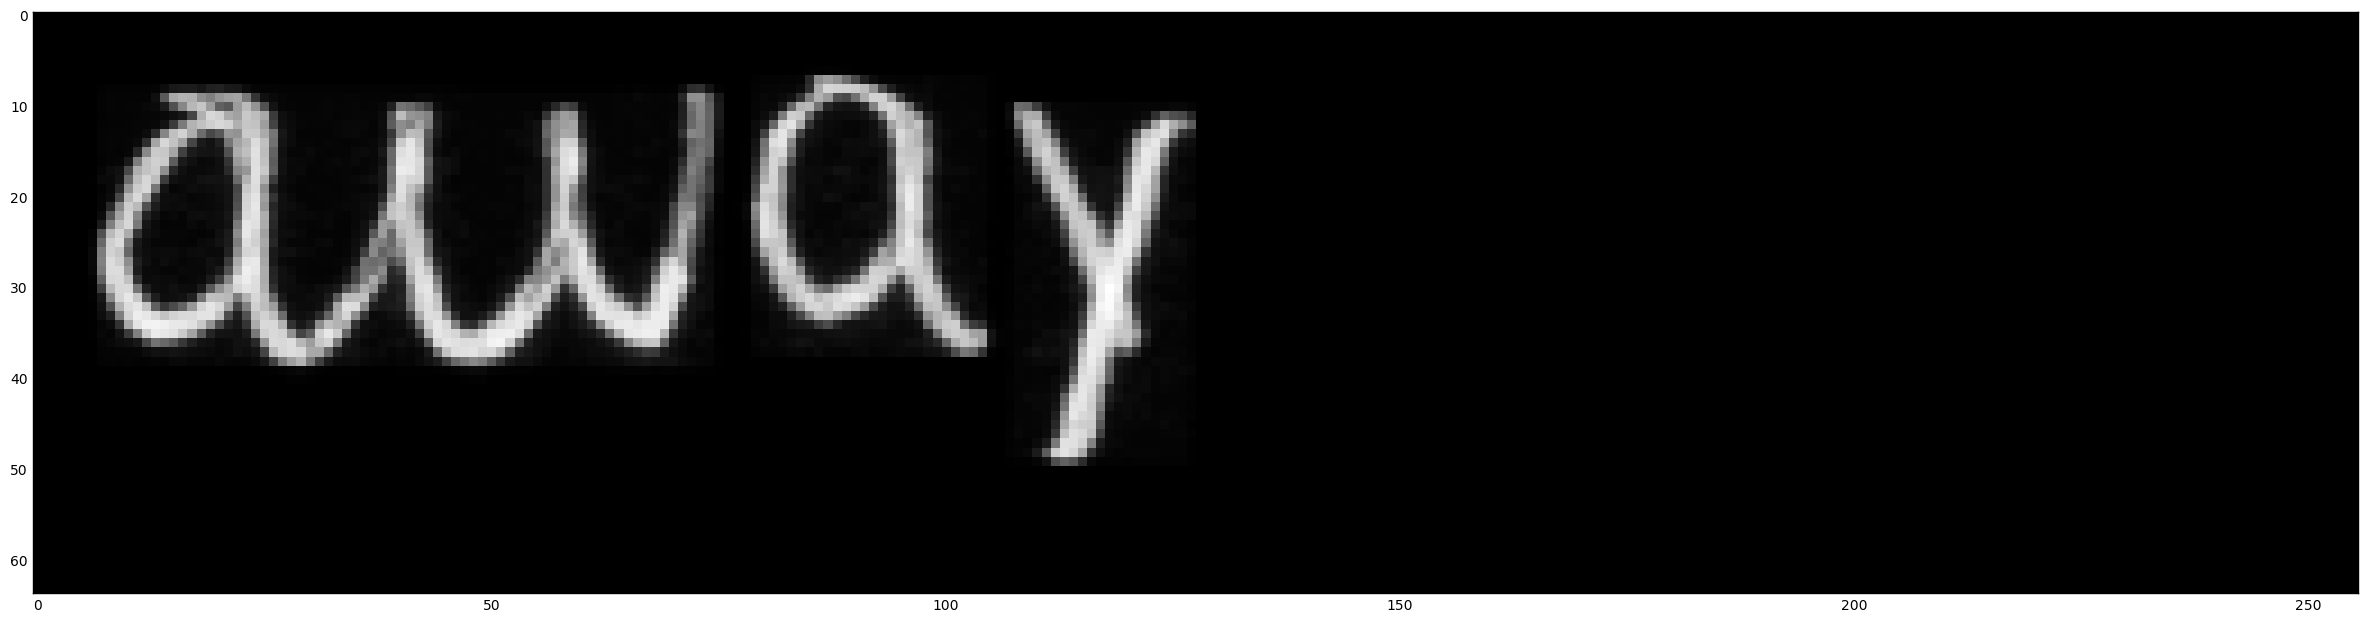

In [17]:
#Check data
i=5900
with h5py.File(source_path + file_name, mode='r') as hdf5_f:
    plt.imshow(hdf5_f.get('X_tst')[i])
    print(hdf5_f.get('image_length_tst')[i], hdf5_f.get('target_tst')[i], hdf5_f.get('target_length_tst')[i])